In [ ]:
# 1) Imports & setup
import sys
from pathlib import Path

# add your scripts/ folder to PYTHONPATH
scripts_path = Path("..") / "scripts"
sys.path.insert(0, str(scripts_path.resolve()))


import torch
from pathlib import Path
import PIL
import matplotlib.pyplot as plt

from img_embedder  import ImgEmbedder
from text_embedder import TextEmbedder
from decoder       import DecoderModel

# Get model path and tckpt_20250702_161219_epoch02_acc0.3523.ptest data path
BASE_DIR: Path = Path().resolve()
CKPT_PATH: Path = BASE_DIR.parent / "ckpts" / "ckpt_20250703_110646_epoch03_acc0.3674.pt" # clip best epoch
TEST_DATA_PATH: Path = BASE_DIR.parent / "data" / "test_images"

MAX_SEQ_LEN = 50  # max sequence length for captions

In [8]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) Instantiate embedders & model
img_embedder  = ImgEmbedder(model_name="openai/clip-vit-base-patch32", choice='CLIP') # or ViT

text_embedder = TextEmbedder("Qwen/Qwen3-Embedding-0.6B",      device=device)

[ImgEmbedder] loading CLIP vision model on cuda
Loaded text embedder 'Qwen/Qwen3-Embedding-0.6B' (vocab=151669, dim=1024) on cuda


In [9]:

# match training hyper-params here
model = DecoderModel(
    image_dim=768,            # ViT-base CLS dim
    hidden_dim=1024,          # Qwen embed dim
    num_heads=8,
    num_layers=6,
    vocab_size=text_embedder.tokenizer.vocab_size,
    max_seq_len=MAX_SEQ_LEN
).to(device)

# load checkpoint
ckpt = torch.load(CKPT_PATH, map_location=device)
model.load_state_dict(ckpt)
model.eval()

RuntimeError: Error(s) in loading state_dict for DecoderModel:
	size mismatch for img_proj.weight: copying a param with shape torch.Size([1024, 512]) from checkpoint, the shape in current model is torch.Size([1024, 768]).

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bos_id = text_embedder.tokenizer.bos_token_id or text_embedder.tokenizer.cls_token_id
eos_id = text_embedder.tokenizer.eos_token_id or text_embedder.tokenizer.sep_token_id

def generate_caption(
    img: PIL.Image.Image,
    max_len: int = MAX_SEQ_LEN,
    temperature: float = 1.0,
    top_k: int = 50
) -> str:
    # 0) pick a valid BOS:
    bos_id = text_embedder.tokenizer.bos_token_id \
          or text_embedder.tokenizer.cls_token_id \
          or text_embedder.tokenizer.eos_token_id
    if bos_id is None:
        raise ValueError("No BOS/CLS/EOS token in tokenizer!")

    eos_id = text_embedder.tokenizer.eos_token_id

    # 1) embed the image once
    img_emb = img_embedder.embed_batch([img]).to(device)  # (1, D_img)

    # 2) start sequence
    generated = [bos_id]

    for _ in range(max_len):
        ids  = torch.tensor([generated], device=device)             
        mask = torch.ones_like(ids, dtype=torch.bool, device=device)

        txt_emb = text_embedder.embed_tokens(ids).to(device)
        with torch.no_grad():
            logits = model(img_emb, txt_emb, mask)   # (1, cur_len, V)

        next_logits = logits[0, -1] / temperature   # (V,)

        # 3) top-k filtering
        if top_k is not None:
            vals, idxs = torch.topk(next_logits, top_k)
            probs = torch.softmax(vals, dim=-1)
            next_id = idxs[torch.multinomial(probs, 1)].item()
        else:
            probs = torch.softmax(next_logits, dim=-1)
            next_id = torch.multinomial(probs, 1).item()

        # 4) optional: block immediate repeats
        if next_id == generated[-1]:
            # choose second-best instead
            _, sorted_idx = torch.sort(next_logits, descending=True)
            next_id = sorted_idx[1].item()

        # 5) stop on EOS
        if eos_id is not None and next_id == eos_id:
            break

        generated.append(next_id)

    # 6) decode (drop the BOS token)
    return text_embedder.tokenizer.decode(
        generated[1:], skip_special_tokens=True
    )



→ itive students of one is playing their game and they can be seen after a game. game. party. game. as an event. game. jersey and the opposing team member holding the ball. but not on the table with other racquet. their


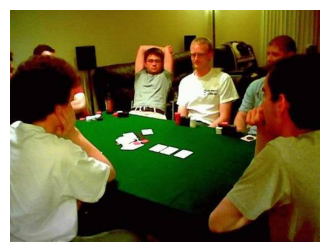

→ ina, his student wearing a hat, is performing a trick over a computer. device. and using a computer screen. screens. lights, and scissors, on the right, while the keyboard instruments in the background of the screen. six spectators to the


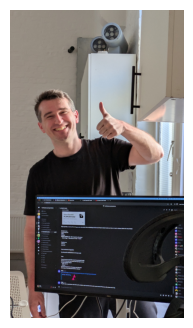

In [ ]:
# 4) Run on  test folder
test_folder = Path(TEST_DATA_PATH)
for img_path in sorted(test_folder.glob("*.jpg"))[:5]:
    img = PIL.Image.open(img_path).convert("RGB")
    cap = generate_caption(img)
    plt.figure(figsize=(4,4))
    plt.imshow(img); plt.axis("off")
    print("→", cap)
    plt.show()
